<a href="https://colab.research.google.com/github/alamgirm/infectious_disease_modelling/blob/master/covid_19_version_iii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure to open in colab to see the plots!


You might want to change the plot sizes; just ctrl+f for "figsize" and change them all (ex.: (20,4) to (10,2))

# Imports

In [0]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

We want to fit the following curve:

# Supplemental and Coronavirus Data

In [0]:
# !! if you get a timeout-error, just click on the link and download the data manually !!

# read the data
beds = pd.read_csv("https://raw.githubusercontent.com/alamgirm/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
#covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
#covid_data["Location"] = covid_data["Country/Region"]

# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

## Plotting

In [0]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None, isLog=False):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")

    f, ax = plt.subplots(1,1,figsize=(20,6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B-%d"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%B-%d"))

    if x_ticks is None:
      ax.set_xlabel('Time (days)')
      if isLog == True:
        #ax.semilogy(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.semilogy(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.semilogy(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.semilogy(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.semilogy(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.semilogy(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
      else:
        #ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')  

    else:
      ax.set_xlabel('Date')      
      if isLog == True:
        ax.semilogy(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.semilogy(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.semilogy(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        #ax.semilogy(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.semilogy(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')
      else:
        #ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        #ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')
      

    ax.title.set_text('extended SEIR-Model')
    ax.yaxis.set_tick_params(length=0)

    #ax.grid(b='True', which='minor', )

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.minorticks_on()
    plt.grid(b=True, which='minor', linestyle='dotted')
    plt.show();
    
    f = plt.figure(figsize=(20,6))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.set_xlabel('Date')
        ax1.xaxis.set_major_formatter(mdates.DateFormatter("%B-%d"))
        ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%B-%d"))


 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.set_xlabel('Date')
        ax2.xaxis.set_major_formatter(mdates.DateFormatter("%B-%d"))
        ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%B-%d"))

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.set_xlabel('Date')
        ax3.xaxis.set_major_formatter(mdates.DateFormatter("%B-%d"))
        ax3.xaxis.set_minor_formatter(mdates.DateFormatter("%B-%d"))

    ax3.title.set_text('Deaths per day')
    #ax3.yaxis.set_tick_params(length=0)
    #ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

# Model

In [0]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [0]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    #R_0_over_time = [3.5 for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

# Fitting

In [0]:
# parameters
file_url="https://docs.google.com/spreadsheets/u/0/d/1742jLWWYbjFdNn2IcPGzHM6UCNnuLrWq9b4xbBzfP_M/export?format=csv"
df = pd.read_csv(file_url)
bddata = df["DeathCum"]
#data = covid_data[covid_data["Location"] == "Bangladesh"]["Value"].values[::-1]
data = df.iloc[:,8].values
agegroups = agegroup_lookup["Bangladesh"]
beds_per_100k = beds_lookup["Bangladesh"]
# most sensitive parameter now
# actual date of first infection - first reporting
# 30 means = the infection started 30 days priod to first reported case
# fit by visual trial and error
outbreak_shift = 20
params_init_min_max = {"R_0_start": (3.0, 1.0, 5.0), "k": (1.1, 0.01, 5.0), "x0": (50, 0, 150), "R_0_end": (0.9, 0.3, 4.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [0]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [0]:
def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [0]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

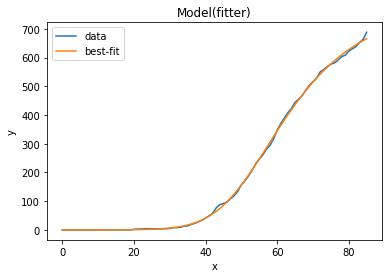

In [0]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)
result.plot_fit(datafmt="-");

In [0]:
result.best_values

{'R_0_end': 0.3782646194129594,
 'R_0_start': 4.756519406695372,
 'k': 0.13971372070158122,
 'prob_C_to_D': 0.5,
 'prob_I_to_C': 0.09999999979757951,
 's': 0.003,
 'x0': 40.772996559895304}

Prediction for Bangladesh
percentage going to ICU: 9.99999997975795; percentage dying in ICU: 50.0


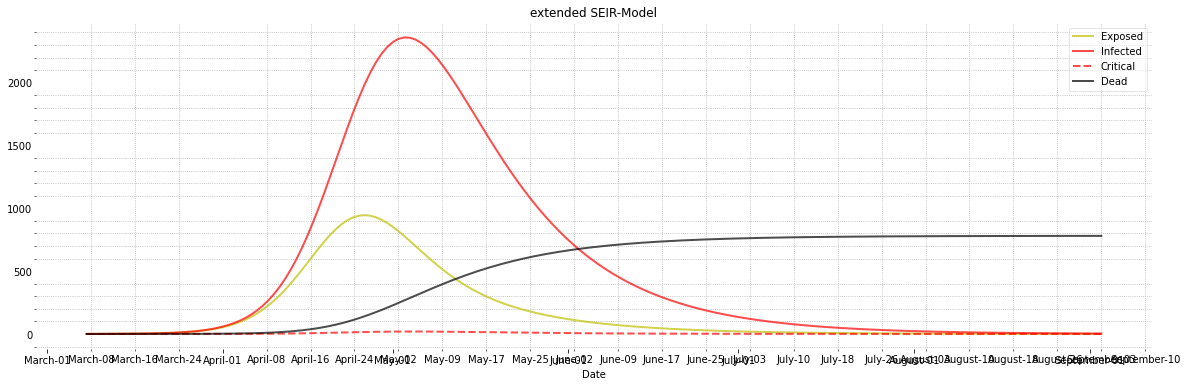

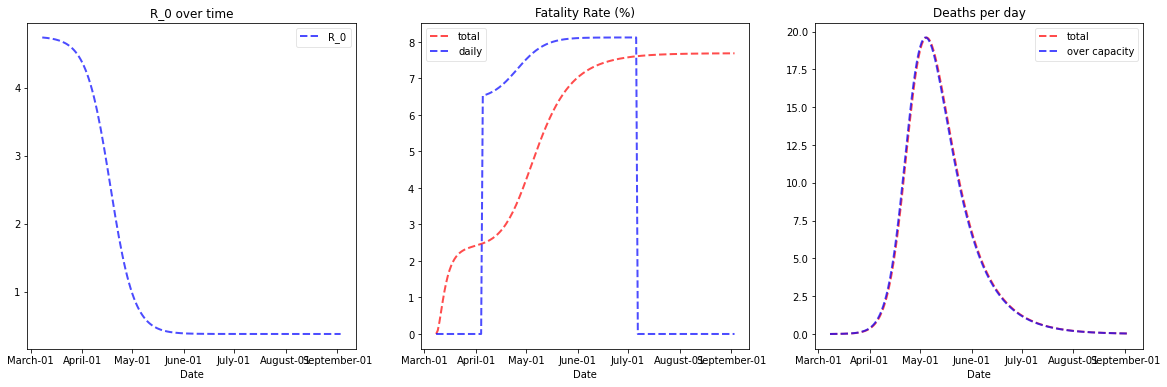

In [0]:

full_days = 180
first_date = np.datetime64(dt.datetime.strptime(df.iloc[:,0].values.min(),"%m/%d/%Y")) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")

base = dt.datetime(2020,3,8)
xticks = [base + dt.timedelta(days=x) for x in range(0,len(x_ticks))] 
print("Prediction for Bangladesh")
plotter(*Model(full_days, agegroup_lookup["Bangladesh"], beds_lookup["Bangladesh"], **result.best_values), x_ticks=xticks, isLog=False);

In [0]:
from datetime import datetime
start_date = datetime.strptime(df.iloc[:,0].values.min(),"%m/%d/%Y")

In [0]:
start_date

datetime.datetime(2020, 3, 8, 0, 0)